# 경로지정

In [1]:
import pandas as pd
from pathlib import Path
import shutil  # 파일 복사용

# -------------------------------------------------------
# 경로 설정
# -------------------------------------------------------
CSV_PATH = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/data/metadata_backup.csv")

# 확인할 행 번호
TARGET_ROW = 119

# -------------------------------------------------------
# CSV 로드 및 행 접근
# -------------------------------------------------------
meta = pd.read_csv(CSV_PATH)

# -------------------------------------------------------
# 개별 경로 생성
# -------------------------------------------------------
FRAME_DIR = Path(str(meta.loc[TARGET_ROW]['frame_path']))
KEYPOINTS_DIR = Path(str(meta.loc[TARGET_ROW]['keypoints_path']))
INTERP_DIR = Path(str(meta.loc[TARGET_ROW]['interp_json_path']))
VIDEO_DIR =  Path(str(meta.loc[TARGET_ROW]['mp4_path']))

# -------------------------------------------------------
# 존재 여부 확인 및 폴더 생성
# -------------------------------------------------------
for p in [FRAME_DIR, KEYPOINTS_DIR, INTERP_DIR, VIDEO_DIR]:
    if not p.exists():
        if p == INTERP_DIR:
            p.mkdir(parents=True, exist_ok=True)
            print(f"📁 생성 완료: {p}")
        else:
            print(f"❌ 없음: {p}")
    else:
        print(f"✅ 존재: {p}")

    
# -------------------------------------------------------
# 현재 처리 대상 이름 변수 분리
# -------------------------------------------------------
parent_name = FRAME_DIR.parent.name                # 상위 폴더명 (예: N01_Ward)
current_name = FRAME_DIR.name                      # 현재 폴더명 (예: lateral__overhead_triceps_extension)
target_name = f"{parent_name}/{current_name}"      # 결합된 이름 생성

# -------------------------------------------------------
# 정보 출력
# -------------------------------------------------------
print(f"\nis_train = {meta.loc[TARGET_ROW]['is_train']}")       # 학습 데이터 여부 출력
print(f"is_train = {meta.loc[TARGET_ROW]['is_val']}")       # 학습 데이터 여부 출력

print(f"\n🎯 현재 처리 대상: {target_name}")                      # 상위폴더/하위폴더 형태로 출력

✅ 존재: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/1_FRAME/AI_dataset/N02/N02_Treatment/lateral__hip_flexion_extension_bobath_table
✅ 존재: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/2_KEYPOINTS/AI_dataset/N02/N02_Treatment/lateral__hip_flexion_extension_bobath_table
✅ 존재: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Treatment/lateral__hip_flexion_extension_bobath_table
✅ 존재: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/3_MP4/AI_dataset/N02/N02_Treatment/lateral__hip_flexion_extension_bobath_table.mp4

is_train = False
is_train = False

🎯 현재 처리 대상: N02_Treatment/lateral__hip_flexion_extension_bobath_table


# JSON 복사

In [71]:
# -------------------------------------------------------
# 🔁 keypoints → interp_json 복사
# -------------------------------------------------------
if KEYPOINTS_DIR.exists():
    for json_file in KEYPOINTS_DIR.glob("*.json"):
        shutil.copy(json_file, INTERP_DIR / json_file.name)  # JSON 복사
    print(f"✅ {len(list(KEYPOINTS_DIR.glob('*.json')))}개 JSON 복사 완료 → {INTERP_DIR}")
else:
    print("⚠️ KEYPOINTS_DIR가 존재하지 않아 복사 스킵됨")

✅ 358개 JSON 복사 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Treatment/lateral__hip_flexion_extension_bobath_table


# 필수 함수

## frame overlay 시각화 함수

In [2]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------------------
# (1) Frame overlay 시각화 함수 (2열 배치, 5~16만 표시)
# -------------------------------------------------------
def visualize_frame_overlay(frame_dir: Path, json_dir: Path, frame_idx: int, window: int = 5):
    """
    frame_idx 기준 ±window 프레임의 skeleton을 시각화 (2열 다중행)
    - COCO 17 중 5~16만 표시
    """
    start_idx = max(0, frame_idx - window)
    end_idx = frame_idx + window + 1
    frame_indices = list(range(start_idx, end_idx))
    n_frames = len(frame_indices)

    # COCO 17개 중 5~16만 남기기
    links = [
        (15, 13), (13, 11),
        (16, 14), (14, 12),
        (11, 12),
        (5, 11), (6, 12),
        (5, 6),
        (5, 7), (7, 9),
        (6, 8), (8, 10)
    ]
    left_points = [5, 7, 9, 11, 13, 15]
    right_points = [6, 8, 10, 12, 14, 16]

    # -------------------------------------------------------
    # Subplot 설정 (2열 자동 행 계산)
    # -------------------------------------------------------
    n_cols = 2
    n_rows = int(np.ceil(n_frames / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.5 * n_rows))
    axes = np.array(axes).reshape(-1)  # 1D로 평탄화

    for ax, idx in zip(axes, frame_indices):
        frame_path = frame_dir / f"{idx:06d}.jpg"
        json_path = json_dir / f"{idx:06d}.json"

        if not frame_path.exists() or not json_path.exists():
            ax.axis("off")
            continue

        frame = cv2.imread(str(frame_path))
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            ax.axis("off")
            continue

        for person in data["instance_info"]:
            kpts = np.array(person["keypoints"])
            for a, b in links:
                if a >= len(kpts) or b >= len(kpts):
                    continue
                pt1, pt2 = tuple(map(int, kpts[a])), tuple(map(int, kpts[b]))
                cv2.line(frame, pt1, pt2, (80, 80, 80), 2)

            for kp_idx, (x, y) in enumerate(kpts):
                if kp_idx < 5 or kp_idx > 16:
                    continue
                if kp_idx in left_points:
                    color = (255, 0, 0)
                elif kp_idx in right_points:
                    color = (0, 0, 255)
                else:
                    color = (0, 255, 0)
                cv2.circle(frame, (int(x), int(y)), 4, color, -1)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax.imshow(frame_rgb)
        ax.set_title(f"Frame {idx:06d}", fontsize=10)
        ax.axis("off")

    # 남는 subplot 숨김
    for ax in axes[n_frames:]:
        ax.axis("off")

    plt.suptitle(f"Skeletons around Frame {frame_idx:06d} (±{window})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [3]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------------------
# (2) 단일 프레임 skeleton 시각화 함수
# -------------------------------------------------------
def visualize_single_frame(frame_dir: Path, json_dir: Path, frame_idx: int, show_kp_idx: bool = True):
    """
    지정한 단일 프레임을 크게 시각화 (5~16 keypoints만 표시)
    - show_kp_idx=True → 각 keypoint 번호도 함께 출력
    """
    frame_path = frame_dir / f"{frame_idx:06d}.jpg"
    json_path = json_dir / f"{frame_idx:06d}.json"

    if not frame_path.exists() or not json_path.exists():
        print(f"❌ Frame {frame_idx:06d}: frame 또는 JSON 없음")
        return

    # ---------------------------------------------------
    # 기본 skeleton 구조 (5~16만)
    # ---------------------------------------------------
    links = [
        (15, 13), (13, 11),
        (16, 14), (14, 12),
        (11, 12),
        (5, 11), (6, 12),
        (5, 6),
        (5, 7), (7, 9),
        (6, 8), (8, 10)
    ]
    left_points = [5, 7, 9, 11, 13, 15]
    right_points = [6, 8, 10, 12, 14, 16]

    # ---------------------------------------------------
    # 데이터 로드
    # ---------------------------------------------------
    frame = cv2.imread(str(frame_path))
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if "instance_info" not in data or not data["instance_info"]:
        print(f"⚠️ Frame {frame_idx:06d}: instance_info 없음")
        return

    # ---------------------------------------------------
    # skeleton overlay
    # ---------------------------------------------------
    for person in data["instance_info"]:
        kpts = np.array(person["keypoints"])
        for a, b in links:
            if a >= len(kpts) or b >= len(kpts):
                continue
            pt1, pt2 = tuple(map(int, kpts[a])), tuple(map(int, kpts[b]))
            cv2.line(frame, pt1, pt2, (80, 80, 80), 3)

        for kp_idx, (x, y) in enumerate(kpts):
            if kp_idx < 5 or kp_idx > 16:
                continue
            if kp_idx in left_points:
                color = (255, 0, 0)
            elif kp_idx in right_points:
                color = (0, 0, 255)
            else:
                color = (0, 255, 0)
            cv2.circle(frame, (int(x), int(y)), 6, color, -1)

            if show_kp_idx:
                cv2.putText(frame, str(kp_idx), (int(x)+5, int(y)-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

    # ---------------------------------------------------
    # 시각화
    # ---------------------------------------------------
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.title(f"Frame {frame_idx:06d}", fontsize=16)
    plt.show()


## 영상 생성 함수

In [4]:
import sys
sys.path.append("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter")

from functions.render_skeleton_video import render_skeleton_video

## IQR 시각화 함수

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

# -------------------------------------------------------
# (함수) keypoints 전체 IQR + Boxplot 4컬럼 시각화 (Outlier 표시 포함)
# -------------------------------------------------------
def plot_keypoint_iqr_overview(json_dir: Path, keypoint_range=(5, 17), whisker: float = 1.5):
    """
    keypoint별 X/Y 좌표 시계열 + Boxplot을 한 행에 표시하며,
    IQR 기반 이상치(Outlier)를 점으로 표시.

    Args:
        json_dir (Path): keypoints JSON 폴더
        keypoint_range (tuple): 분석할 keypoints 범위 (기본 5~16)
        whisker (float): IQR 배수 (1.5 → 일반적인 Tukey 기준)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    all_kpts = []
    for jfile in tqdm(json_files):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])  # (17, 2)
        all_kpts.append(kpts)

    all_kpts = np.stack(all_kpts)  # (frame, kp, 2)
    frames = np.arange(len(all_kpts))

    # -------------------------------------------------------
    # IQR 계산 함수
    # -------------------------------------------------------
    def compute_iqr(values, whisker):
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower = q1 - whisker * iqr
        upper = q3 + whisker * iqr
        return q1, q3, iqr, lower, upper

    # -------------------------------------------------------
    # 시각화 준비
    # -------------------------------------------------------
    kp_indices = list(range(*keypoint_range))
    n_kp = len(kp_indices)
    fig, axes = plt.subplots(n_kp, 4, figsize=(18, 2.8 * n_kp))

    if n_kp == 1:
        axes = axes.reshape(1, 4)

    for row_idx, kp_idx in enumerate(kp_indices):
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]

        valid_x = xs[~np.isnan(xs)]
        valid_y = ys[~np.isnan(ys)]
        if len(valid_x) < 5:
            continue

        # IQR 계산
        q1x, q3x, iqrx, lower_x, upper_x = compute_iqr(valid_x, whisker)
        q1y, q3y, iqry, lower_y, upper_y = compute_iqr(valid_y, whisker)

        # 이상치 마스크
        outlier_x_mask = (xs < lower_x) | (xs > upper_x)
        outlier_y_mask = (ys < lower_y) | (ys > upper_y)

        # ------------------------------
        # (1) X 시계열 + outlier
        # ------------------------------
        ax = axes[row_idx, 0]
        ax.plot(frames, xs, color="dodgerblue", linewidth=1)
        ax.axhline(lower_x, color="red", linestyle="--", alpha=0.5)
        ax.axhline(upper_x, color="red", linestyle="--", alpha=0.5)
        ax.scatter(frames[outlier_x_mask], xs[outlier_x_mask],
                   color="crimson", s=15, zorder=3, label="Outlier")
        ax.set_title(f"kpt{kp_idx} X", fontsize=9)
        ax.grid(True, linestyle="--", alpha=0.4)

        # ------------------------------
        # (2) Y 시계열 + outlier
        # ------------------------------
        ax = axes[row_idx, 1]
        ax.plot(frames, ys, color="darkorange", linewidth=1)
        ax.axhline(lower_y, color="red", linestyle="--", alpha=0.5)
        ax.axhline(upper_y, color="red", linestyle="--", alpha=0.5)
        ax.scatter(frames[outlier_y_mask], ys[outlier_y_mask],
                   color="purple", s=15, zorder=3, label="Outlier")
        ax.set_title(f"kpt{kp_idx} Y", fontsize=9)
        ax.grid(True, linestyle="--", alpha=0.4)

        # ------------------------------
        # (3) X Boxplot (Outlier 자동 표시)
        # ------------------------------
        ax = axes[row_idx, 2]
        ax.boxplot(xs[~np.isnan(xs)],
                patch_artist=True,
                whis=whisker,                     # ✅ 여기 추가!
                boxprops=dict(facecolor="lightblue", color="navy"),
                medianprops=dict(color="red"),
                flierprops=dict(marker='o', markerfacecolor='crimson',
                                markersize=4, linestyle='none'))

        ax.set_title("X Box", fontsize=9)
        ax.set_xticks([])

        # ------------------------------
        # (4) Y Boxplot (Outlier 자동 표시)
        # ------------------------------
        ax = axes[row_idx, 3]
        ax.boxplot(ys[~np.isnan(ys)],
                patch_artist=True,
                whis=whisker,                     # ✅ 동일하게 반영
                boxprops=dict(facecolor="lightcoral", color="maroon"),
                medianprops=dict(color="black"),
                flierprops=dict(marker='o', markerfacecolor='purple',
                                markersize=4, linestyle='none'))

        ax.set_title("Y Box", fontsize=9)
        ax.set_xticks([])

    plt.suptitle(f"IQR Overview per Keypoint (whisker={whisker})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [19]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) IQR 기반 Outlier 선형보간 (연속 구간 대응)
# -------------------------------------------------------
def interpolate_outliers(json_dir: Path, target_kps=[14, 16], whisker=1.5, save_dir: Path = None):
    """
    지정된 keypoints에서 IQR 기반 이상치를 선형 보간으로 수정
    (연속 outlier 구간도 자연스럽게 처리)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    # -------------------------------------------------------
    # 1️⃣ 전체 keypoints 로드
    # -------------------------------------------------------
    all_kpts = []
    for jfile in json_files:
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])  # (17, 2)
        all_kpts.append(kpts)
    all_kpts = np.stack(all_kpts)
    frames = np.arange(len(all_kpts))

    # -------------------------------------------------------
    # 2️⃣ IQR 계산 함수
    # -------------------------------------------------------
    def compute_iqr(values, whisker):
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower = q1 - whisker * iqr
        upper = q3 + whisker * iqr
        return lower, upper

    # -------------------------------------------------------
    # 3️⃣ 연속 outlier 구간을 묶어서 보간
    # -------------------------------------------------------
    for kp_idx in target_kps:
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]

        # NaN 제거 후 IQR 계산
        valid_x = xs[~np.isnan(xs)]
        valid_y = ys[~np.isnan(ys)]
        if len(valid_x) < 5:
            continue

        lower_x, upper_x = compute_iqr(valid_x, whisker)
        lower_y, upper_y = compute_iqr(valid_y, whisker)

        outlier_mask_x = (xs < lower_x) | (xs > upper_x)
        outlier_mask_y = (ys < lower_y) | (ys > upper_y)
        outlier_mask = outlier_mask_x | outlier_mask_y
        outlier_indices = np.where(outlier_mask)[0]

        if len(outlier_indices) == 0:
            print(f"[INFO] kpt{kp_idx}: Outlier 없음 ✅")
            continue

        print(f"[INFO] kpt{kp_idx}: {len(outlier_indices)}개 Outlier → 연속 구간 단위 보간 중...")

        # 연속 outlier 그룹 묶기
        groups = []
        current = [outlier_indices[0]]
        for f in outlier_indices[1:]:
            if f == current[-1] + 1:
                current.append(f)
            else:
                groups.append(current)
                current = [f]
        groups.append(current)

        # 각 그룹별 보간 수행
        for g in groups:
            left = g[0] - 1
            right = g[-1] + 1

            # 양끝단은 보간 불가
            if left < 0 or right >= len(xs):
                continue
            if np.isnan(xs[left]) or np.isnan(xs[right]):
                continue

            # X, Y 각각 보간
            num_points = len(g) + 2
            interp_x = np.linspace(xs[left], xs[right], num_points)[1:-1]
            interp_y = np.linspace(ys[left], ys[right], num_points)[1:-1]

            # 업데이트
            for idx, x_val, y_val in zip(g, interp_x, interp_y):
                all_kpts[idx, kp_idx, 0] = x_val
                all_kpts[idx, kp_idx, 1] = y_val

        print(f"    → 보간 완료 구간: {[ (g[0], g[-1]) for g in groups ]}")

    # -------------------------------------------------------
    # 4️⃣ 보간 후 저장
    # -------------------------------------------------------
    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    for i, jfile in enumerate(tqdm(json_files, desc="Saving interpolated JSON")):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            continue
        data["instance_info"][0]["keypoints"] = all_kpts[i].tolist()

        out_path = save_dir / jfile.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ Outlier 보간 완료 (연속 구간 포함, keypoints={target_kps}, whisker={whisker}) → {save_dir}")


## smoothing 함수

In [7]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

def smooth_keypoints(json_dir: Path,
                     target_kps: list,
                     window: int = 5,
                     method: str = "moving",
                     save_dir: Path = None):
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 → smoothing keypoints: {target_kps}")

    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    all_kpts = []
    for jfile in json_files:
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])
        all_kpts.append(kpts)
    all_kpts = np.stack(all_kpts)

    for kp_idx in target_kps:
        x = all_kpts[:, kp_idx, 0]
        y = all_kpts[:, kp_idx, 1]

        if method == "moving":
            # ✅ Pandas rolling 평균 사용 (경계 안전)
            x = pd.Series(x).rolling(window, center=True, min_periods=1).mean().to_numpy()
            y = pd.Series(y).rolling(window, center=True, min_periods=1).mean().to_numpy()
        elif method == "gaussian":
            x = gaussian_filter1d(x, sigma=window / 2)
            y = gaussian_filter1d(y, sigma=window / 2)
        else:
            raise ValueError("❌ method는 'moving' 또는 'gaussian'만 지원합니다.")

        all_kpts[:, kp_idx, 0] = x
        all_kpts[:, kp_idx, 1] = y

    for i, jfile in enumerate(tqdm(json_files, desc="Saving smoothed JSON")):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            continue
        data["instance_info"][0]["keypoints"] = all_kpts[i].tolist()

        out_path = save_dir / jfile.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ Smoothing 완료 → {save_dir}")


## keypoints 고정 함수

In [8]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) 특정 keypoints를 기준 프레임 좌표로 고정
# -------------------------------------------------------
def fix_keypoints_across_frames(json_dir: Path, ref_frame: int, target_kps: list, save_dir: Path = None):
    """
    지정한 keypoints를 기준 프레임(ref_frame)의 좌표로 모든 프레임에 고정
    
    Args:
        json_dir (Path): 입력 JSON 폴더
        ref_frame (int): 기준 프레임 번호 (예: 315)
        target_kps (list): 고정시킬 keypoint index 리스트 (예: [8, 10])
        save_dir (Path): 결과 저장 폴더 (None이면 원본 덮어쓰기)
    """
    json_files = sorted(json_dir.glob("*.json"))
    ref_path = json_dir / f"{ref_frame:06d}.json"

    if not ref_path.exists():
        print(f"❌ 기준 프레임 JSON 없음: {ref_path}")
        return

    # 기준 프레임에서 keypoints 추출
    with open(ref_path, "r", encoding="utf-8") as f:
        ref_data = json.load(f)
    if "instance_info" not in ref_data or not ref_data["instance_info"]:
        print(f"⚠️ 기준 프레임({ref_frame})에 instance_info 없음")
        return

    ref_kpts = np.array(ref_data["instance_info"][0]["keypoints"])  # (17, 2)
    fixed_values = {kp_idx: ref_kpts[kp_idx].copy() for kp_idx in target_kps}
    print(f"[INFO] 기준 프레임 {ref_frame}의 {target_kps}번 keypoints 좌표 고정값 → {fixed_values}")

    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    # -------------------------------------------------------
    # 모든 프레임에 고정값 적용
    # -------------------------------------------------------
    for jpath in tqdm(json_files, desc="Fixing keypoints"):
        with open(jpath, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            continue

        kpts = np.array(data["instance_info"][0]["keypoints"])
        for kp_idx, fixed_val in fixed_values.items():
            if kp_idx < len(kpts):
                kpts[kp_idx] = fixed_val  # 좌표 고정
        data["instance_info"][0]["keypoints"] = kpts.tolist()

        out_path = save_dir / jpath.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ {target_kps}번 keypoints를 프레임 {ref_frame} 기준으로 전체 고정 완료 → {save_dir}")


## velocity Outlier 함수

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) keypoint 속도 기반 outlier 시각화
# -------------------------------------------------------
def plot_velocity_outliers(json_dir: Path, target_kps=[14, 16], z_thresh: float = 3.0):
    """
    keypoint 속도 변화 기반 outlier 탐지 및 시각화
    (시각화 + outlier frame 번호 출력)

    Args:
        json_dir (Path): keypoints JSON 폴더
        target_kps (list): 확인할 keypoint 인덱스 리스트
        z_thresh (float): z-score 기준 임계값 (기본 3.0)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    # -------------------------------------------------------
    # 1️⃣ keypoints 로드
    # -------------------------------------------------------
    all_kpts = []
    for jfile in tqdm(json_files, desc="Loading JSON"):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])
        all_kpts.append(kpts)

    all_kpts = np.stack(all_kpts)  # (frame, kp, 2)
    frames = np.arange(len(all_kpts))

    # -------------------------------------------------------
    # 2️⃣ 각 keypoint별 속도 계산 및 이상치 탐지
    # -------------------------------------------------------
    for kp_idx in target_kps:
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]

        # NaN 처리 (보간 없이)
        mask_valid = ~np.isnan(xs) & ~np.isnan(ys)
        if mask_valid.sum() < 3:
            print(f"[WARN] kpt{kp_idx}: 유효 데이터가 너무 적음, skip")
            continue

        xs = xs[mask_valid]
        ys = ys[mask_valid]
        valid_frames = frames[mask_valid]

        # 속도 계산 (프레임 간 변화량)
        vx = np.diff(xs)
        vy = np.diff(ys)
        speed = np.sqrt(vx**2 + vy**2)  # 전체 속도 크기

        # z-score 기반 outlier 판정
        z_vx = (vx - np.mean(vx)) / (np.std(vx) + 1e-6)
        z_vy = (vy - np.mean(vy)) / (np.std(vy) + 1e-6)
        z_speed = (speed - np.mean(speed)) / (np.std(speed) + 1e-6)

        outlier_mask_x = np.abs(z_vx) > z_thresh
        outlier_mask_y = np.abs(z_vy) > z_thresh
        outlier_mask_speed = np.abs(z_speed) > z_thresh

        outlier_frames_x = valid_frames[1:][outlier_mask_x]
        outlier_frames_y = valid_frames[1:][outlier_mask_y]
        outlier_frames_speed = valid_frames[1:][outlier_mask_speed]

        # 로그 출력
        print(f"\n[INFO] Keypoint {kp_idx}")
        print(f"  X outliers ({len(outlier_frames_x)}): {outlier_frames_x.tolist()}")
        print(f"  Y outliers ({len(outlier_frames_y)}): {outlier_frames_y.tolist()}")
        print(f"  Speed outliers ({len(outlier_frames_speed)}): {outlier_frames_speed.tolist()}")

        # -------------------------------------------------------
        # 3️⃣ 시각화 (X, Y, Speed 각각)
        # -------------------------------------------------------
        fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
        fig.suptitle(f"Velocity-based Outlier Detection (Keypoint {kp_idx}, z>{z_thresh})", fontsize=14)

        # X 변화량
        axes[0].plot(valid_frames[1:], vx, color="dodgerblue", label="ΔX")
        axes[0].scatter(outlier_frames_x, vx[outlier_mask_x], color="red", s=25, label="Outlier")
        axes[0].set_ylabel("ΔX (pixels)")
        axes[0].legend()
        axes[0].grid(True, linestyle="--", alpha=0.4)

        # Y 변화량
        axes[1].plot(valid_frames[1:], vy, color="darkorange", label="ΔY")
        axes[1].scatter(outlier_frames_y, vy[outlier_mask_y], color="purple", s=25, label="Outlier")
        axes[1].set_ylabel("ΔY (pixels)")
        axes[1].legend()
        axes[1].grid(True, linestyle="--", alpha=0.4)

        # Speed
        axes[2].plot(valid_frames[1:], speed, color="gray", label="Speed = √(ΔX²+ΔY²)")
        axes[2].scatter(outlier_frames_speed, speed[outlier_mask_speed],
                        color="crimson", s=30, label="Outlier")
        axes[2].set_xlabel("Frame Index")
        axes[2].set_ylabel("Speed (pixels/frame)")
        axes[2].legend()
        axes[2].grid(True, linestyle="--", alpha=0.4)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


In [10]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) 연속 Outlier 구간까지 선형보간
# -------------------------------------------------------
def interpolate_velocity_outliers(json_dir: Path, target_kps=[14, 16], z_thresh: float = 3.0, save_dir: Path = None):
    """
    keypoint 속도(z-score) 기반 Outlier 자동 선형보간 (연속 outlier 구간 지원)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    # 1️⃣ JSON 로드
    all_kpts = []
    for jfile in json_files:
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])
        all_kpts.append(kpts)

    all_kpts = np.stack(all_kpts)
    frames = np.arange(len(all_kpts))

    # 2️⃣ keypoint별 보간
    for kp_idx in target_kps:
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]
        mask_valid = ~np.isnan(xs) & ~np.isnan(ys)
        valid_frames = frames[mask_valid]
        xs = xs[mask_valid]
        ys = ys[mask_valid]

        if len(valid_frames) < 3:
            print(f"[WARN] kpt{kp_idx}: 유효 프레임이 부족합니다.")
            continue

        # 속도 계산
        vx, vy = np.diff(xs), np.diff(ys)
        speed = np.sqrt(vx**2 + vy**2)
        z_vx = (vx - np.mean(vx)) / (np.std(vx) + 1e-6)
        z_vy = (vy - np.mean(vy)) / (np.std(vy) + 1e-6)
        z_speed = (speed - np.mean(speed)) / (np.std(speed) + 1e-6)
        outlier_mask = (np.abs(z_vx) > z_thresh) | (np.abs(z_vy) > z_thresh) | (np.abs(z_speed) > z_thresh)
        outlier_frames = valid_frames[1:][outlier_mask]

        if len(outlier_frames) == 0:
            print(f"[INFO] kpt{kp_idx}: Outlier 없음 ✅")
            continue

        print(f"[INFO] kpt{kp_idx}: {len(outlier_frames)}개 Outlier → 연속 구간 단위 보간 중...")

        # 3️⃣ 연속 outlier 구간 식별
        groups = []
        current = [outlier_frames[0]]
        for f in outlier_frames[1:]:
            if f == current[-1] + 1:
                current.append(f)
            else:
                groups.append(current)
                current = [f]
        groups.append(current)

        # 4️⃣ 각 구간별 선형보간
        for g in groups:
            left = g[0] - 1
            right = g[-1] + 1
            if left < valid_frames[0] or right > valid_frames[-1]:
                continue  # 양끝은 skip

            # 선형보간 구간
            x_left, x_right = all_kpts[left, kp_idx, 0], all_kpts[right, kp_idx, 0]
            y_left, y_right = all_kpts[left, kp_idx, 1], all_kpts[right, kp_idx, 1]
            num = len(g) + 2  # 양쪽 포함 길이
            interp_x = np.linspace(x_left, x_right, num)[1:-1]
            interp_y = np.linspace(y_left, y_right, num)[1:-1]

            for f, ix, iy in zip(g, interp_x, interp_y):
                all_kpts[f, kp_idx, 0] = ix
                all_kpts[f, kp_idx, 1] = iy

            print(f"    → 보간 구간 {g[0]}~{g[-1]} ({len(g)}프레임) 완료")

    # 5️⃣ JSON 저장
    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    for i, jfile in enumerate(tqdm(json_files, desc="Saving interpolated JSON")):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            continue
        data["instance_info"][0]["keypoints"] = all_kpts[i].tolist()

        out_path = save_dir / jfile.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ 연속 outlier 보간 완료 (keypoints={target_kps}, z_thresh={z_thresh}) → {save_dir}")


## 특정 인물만 남기기

In [11]:
def extract_center_person_with_tracking(
    json_dir: Path, 
    sample_ratio: float = 0.1,
    max_movement: float = 150.0  # 프레임 간 최대 이동 거리 (픽셀)
):
    """
    간단한 tracking 기반 중앙 인물 추출 (급격한 이동 필터링)
    
    Args:
        json_dir: JSON 파일들이 있는 디렉토리
        sample_ratio: 주인공 선택에 사용할 프레임 비율 (0.1 = 10%)
        max_movement: 프레임 간 최대 허용 이동 거리 (픽셀)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 프레임 처리 시작...")
    
    # Step 1: 샘플 프레임에서 주인공 선택
    sample_size = max(10, int(len(json_files) * sample_ratio))
    sample_indices = np.linspace(0, len(json_files)-1, sample_size, dtype=int)
    
    print(f"[INFO] Step 1: {sample_size}개 샘플에서 주인공 선택 중...")
    
    all_candidates = []  # [(frame_idx, person_idx, score, keypoints)]
    
    for idx in tqdm(sample_indices, desc="샘플링"):
        with open(json_files[idx], "r", encoding="utf-8") as f:
            data = json.load(f)
        
        if "instance_info" not in data or not data["instance_info"]:
            continue
        
        # 프레임 크기 추정 (keypoints로부터)
        all_kpts = []
        for person in data["instance_info"]:
            kpts = np.array(person["keypoints"])
            valid = kpts[~np.isnan(kpts).any(axis=1)]
            if len(valid) > 0:
                all_kpts.extend(valid)
        
        if not all_kpts:
            continue
        
        all_kpts = np.array(all_kpts)
        w = np.max(all_kpts[:, 0]) - np.min(all_kpts[:, 0])
        h = np.max(all_kpts[:, 1]) - np.min(all_kpts[:, 1])
        center_frame = np.array([w / 2 + np.min(all_kpts[:, 0]), 
                                  h / 2 + np.min(all_kpts[:, 1])])
        
        # 각 사람 점수 계산
        for person_idx, person in enumerate(data["instance_info"]):
            kpts = np.array(person["keypoints"])
            valid = kpts[~np.isnan(kpts).any(axis=1)]
            
            if len(valid) == 0:
                continue
            
            # bbox 크기
            x_min, y_min = np.min(valid, axis=0)
            x_max, y_max = np.max(valid, axis=0)
            area = (x_max - x_min) * (y_max - y_min)
            
            # 중심점
            center = np.mean(valid, axis=0)
            dist = np.linalg.norm(center - center_frame)
            
            # 점수 (거리 - 크기*가중치)
            area_norm = area / (w * h) if w * h > 0 else 0
            score = dist - area_norm * ((w + h) / 2)
            
            all_candidates.append((idx, person_idx, score, valid))
    
    if not all_candidates:
        print("❌ 후보를 찾을 수 없습니다.")
        return
    
    # 가장 좋은 점수의 사람을 주인공으로 선택
    all_candidates.sort(key=lambda x: x[2])
    main_frame_idx, main_person_idx, main_score, main_kpts = all_candidates[0]
    
    print(f"✅ 주인공 선택: 프레임 {main_frame_idx}, 사람 {main_person_idx} (점수: {main_score:.2f})")
    
    # Step 2: 전체 프레임에서 주인공 tracking
    print(f"[INFO] Step 2: 주인공 tracking 중... (최대 이동: {max_movement}px)")
    
    def keypoint_distance(kpts1, kpts2):
        """두 keypoint 세트 간 중심점 거리"""
        valid1 = kpts1[~np.isnan(kpts1).any(axis=1)]
        valid2 = kpts2[~np.isnan(kpts2).any(axis=1)]
        if len(valid1) == 0 or len(valid2) == 0:
            return float('inf')
        
        center1 = np.mean(valid1, axis=0)
        center2 = np.mean(valid2, axis=0)
        return np.linalg.norm(center1 - center2)
    
    # 주인공의 현재 keypoints와 위치
    current_main_kpts = main_kpts
    current_center = np.mean(main_kpts, axis=0)
    
    filtered_count = 0
    lost_track_count = 0
    
    for json_file in tqdm(json_files, desc="Tracking & 필터링"):
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        if "instance_info" not in data or not data["instance_info"]:
            data["instance_info"] = []
            with open(json_file, "w", encoding="utf-8") as f:
                json.dump(data, f, ensure_ascii=False, indent=2)
            lost_track_count += 1
            continue
        
        # 현재 주인공과 가장 가까운 사람 찾기 (급격한 이동 필터링)
        best_distance = float('inf')
        best_person = None
        best_kpts = None
        
        for person in data["instance_info"]:
            kpts = np.array(person["keypoints"])
            valid = kpts[~np.isnan(kpts).any(axis=1)]
            
            if len(valid) == 0:
                continue
            
            # 중심점 거리 계산
            person_center = np.mean(valid, axis=0)
            movement = np.linalg.norm(person_center - current_center)
            
            # 너무 많이 이동했으면 제외
            if movement > max_movement:
                continue
            
            dist = keypoint_distance(current_main_kpts, valid)
            
            if dist < best_distance:
                best_distance = dist
                best_person = person
                best_kpts = valid
        
        # 주인공만 남기기
        if best_person is not None:
            data["instance_info"] = [best_person]
            filtered_count += 1
            # 추적 성공 시에만 위치 업데이트
            current_main_kpts = best_kpts
            current_center = np.mean(best_kpts, axis=0)
        else:
            # 추적 실패 (급격한 이동 or 사람 없음)
            data["instance_info"] = []
            lost_track_count += 1
            # 위치는 유지 (다음 프레임에서 다시 찾기 시도)
        
        with open(json_file, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
    
    print(f"✅ 완료: {filtered_count}/{len(json_files)} 프레임에서 주인공 검출")
    print(f"⚠️  추적 실패: {lost_track_count} 프레임")
    print(f"✅ JSON 파일 덮어쓰기 완료 → {json_dir}")

## 선형 보간 함수

In [12]:
import json
import numpy as np
from pathlib import Path

# -------------------------------------------------------
# (함수) 연속 프레임 구간 단위 keypoints 선형보간
# -------------------------------------------------------
def manual_linear_interpolate_frames(json_dir: Path, target_frames, target_kps: list):
    """
    여러 프레임(target_frames) 중 연속된 구간은 하나로 묶어
    구간 양끝 기준으로 선형보간 수행.
    단일 프레임은 양옆 (frame-1, frame+1) 기준으로 보간.

    Args:
        json_dir (Path): keypoints JSON 폴더
        target_frames (int | list[int]): 보간할 프레임 번호(들)
        target_kps (list): 보간할 keypoint 인덱스 리스트
    """
    # 단일 프레임도 리스트로 처리
    if isinstance(target_frames, int):
        target_frames = [target_frames]
    target_frames = sorted(set(target_frames))

    # JSON 인덱스 매핑
    json_files = {int(p.stem): p for p in sorted(json_dir.glob("*.json"))}
    available_frames = sorted(json_files.keys())

    print(f"[INFO] 총 {len(target_frames)}개 target frame → 연속 구간 단위 보간 시작")

    # -------------------------------------------------------
    # 1️⃣ 연속 프레임 구간 묶기
    # -------------------------------------------------------
    groups = []
    current = [target_frames[0]]
    for f in target_frames[1:]:
        if f == current[-1] + 1:
            current.append(f)
        else:
            groups.append(current)
            current = [f]
    groups.append(current)

    # -------------------------------------------------------
    # 2️⃣ 각 그룹별 보간 수행
    # -------------------------------------------------------
    for group in groups:
        if len(group) == 1:
            # 단일 프레임 보간 (prev/next 기준)
            frame = group[0]
            prev_frame, next_frame = frame - 1, frame + 1

            # 필요한 파일 확인
            if prev_frame not in json_files or next_frame not in json_files:
                print(f"⚠️ Frame {frame}: 양옆 JSON 부족 → skip")
                continue

            with open(json_files[prev_frame], "r", encoding="utf-8") as f:
                prev_data = json.load(f)
            with open(json_files[next_frame], "r", encoding="utf-8") as f:
                next_data = json.load(f)
            with open(json_files[frame], "r", encoding="utf-8") as f:
                target_data = json.load(f)

            if not prev_data.get("instance_info") or not next_data.get("instance_info"):
                print(f"⚠️ Frame {frame}: 양옆 frame에 instance_info 없음 → skip")
                continue

            prev_kpts = np.array(prev_data["instance_info"][0]["keypoints"])
            next_kpts = np.array(next_data["instance_info"][0]["keypoints"])
            target_kpts = np.array(target_data["instance_info"][0]["keypoints"])

            for kp_idx in target_kps:
                target_kpts[kp_idx, 0] = (prev_kpts[kp_idx, 0] + next_kpts[kp_idx, 0]) / 2
                target_kpts[kp_idx, 1] = (prev_kpts[kp_idx, 1] + next_kpts[kp_idx, 1]) / 2

            target_data["instance_info"][0]["keypoints"] = target_kpts.tolist()
            with open(json_files[frame], "w", encoding="utf-8") as f:
                json.dump(target_data, f, ensure_ascii=False, indent=2)

            print(f"✅ Frame {frame}: 단일 프레임 보간 완료 ({target_kps})")

        else:
            # 연속 구간 보간 (start-1, end+1 기준)
            start, end = group[0], group[-1]
            left, right = start - 1, end + 1

            if left not in json_files or right not in json_files:
                print(f"⚠️ Frames {group}: 경계 JSON 부족 → skip")
                continue

            with open(json_files[left], "r", encoding="utf-8") as f:
                left_data = json.load(f)
            with open(json_files[right], "r", encoding="utf-8") as f:
                right_data = json.load(f)

            if not left_data.get("instance_info") or not right_data.get("instance_info"):
                print(f"⚠️ Frames {group}: 경계 instance_info 없음 → skip")
                continue

            left_kpts = np.array(left_data["instance_info"][0]["keypoints"])
            right_kpts = np.array(right_data["instance_info"][0]["keypoints"])

            num_points = len(group) + 2  # 양쪽 포함 전체 길이
            for kp_idx in target_kps:
                x_vals = np.linspace(left_kpts[kp_idx, 0], right_kpts[kp_idx, 0], num_points)[1:-1]
                y_vals = np.linspace(left_kpts[kp_idx, 1], right_kpts[kp_idx, 1], num_points)[1:-1]

                for i, frame in enumerate(group):
                    json_path = json_files[frame]
                    with open(json_path, "r", encoding="utf-8") as f:
                        data = json.load(f)
                    if not data.get("instance_info"):
                        continue
                    kpts = np.array(data["instance_info"][0]["keypoints"])
                    kpts[kp_idx, 0] = x_vals[i]
                    kpts[kp_idx, 1] = y_vals[i]
                    data["instance_info"][0]["keypoints"] = kpts.tolist()

                    with open(json_path, "w", encoding="utf-8") as f:
                        json.dump(data, f, ensure_ascii=False, indent=2)

            print(f"✅ Frames {group[0]}~{group[-1]}: 연속 구간 보간 완료 ({target_kps})")

    print("🎯 모든 지정 프레임 보간 완료 ✅")


# 시각화

## frame overlay 시각화

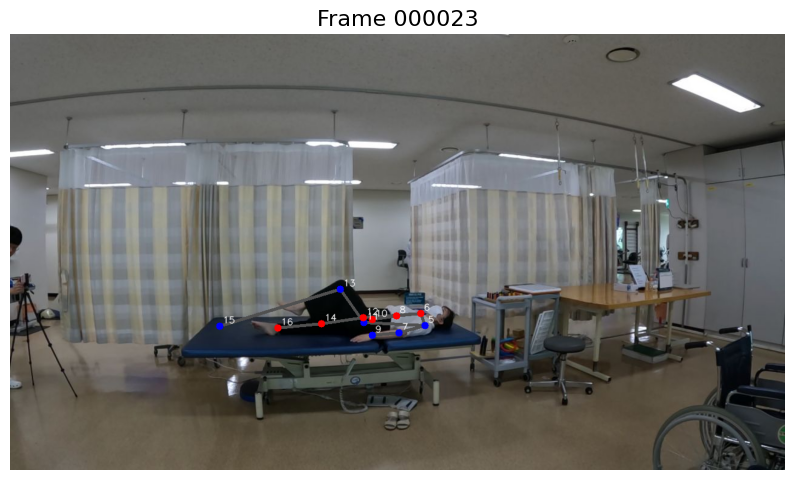

In [69]:
# 단일 프레임 확대 보기
visualize_single_frame(
    frame_dir=FRAME_DIR,
    json_dir=INTERP_DIR,
    frame_idx=23,
    show_kp_idx=True   # keypoint 번호 표시
)


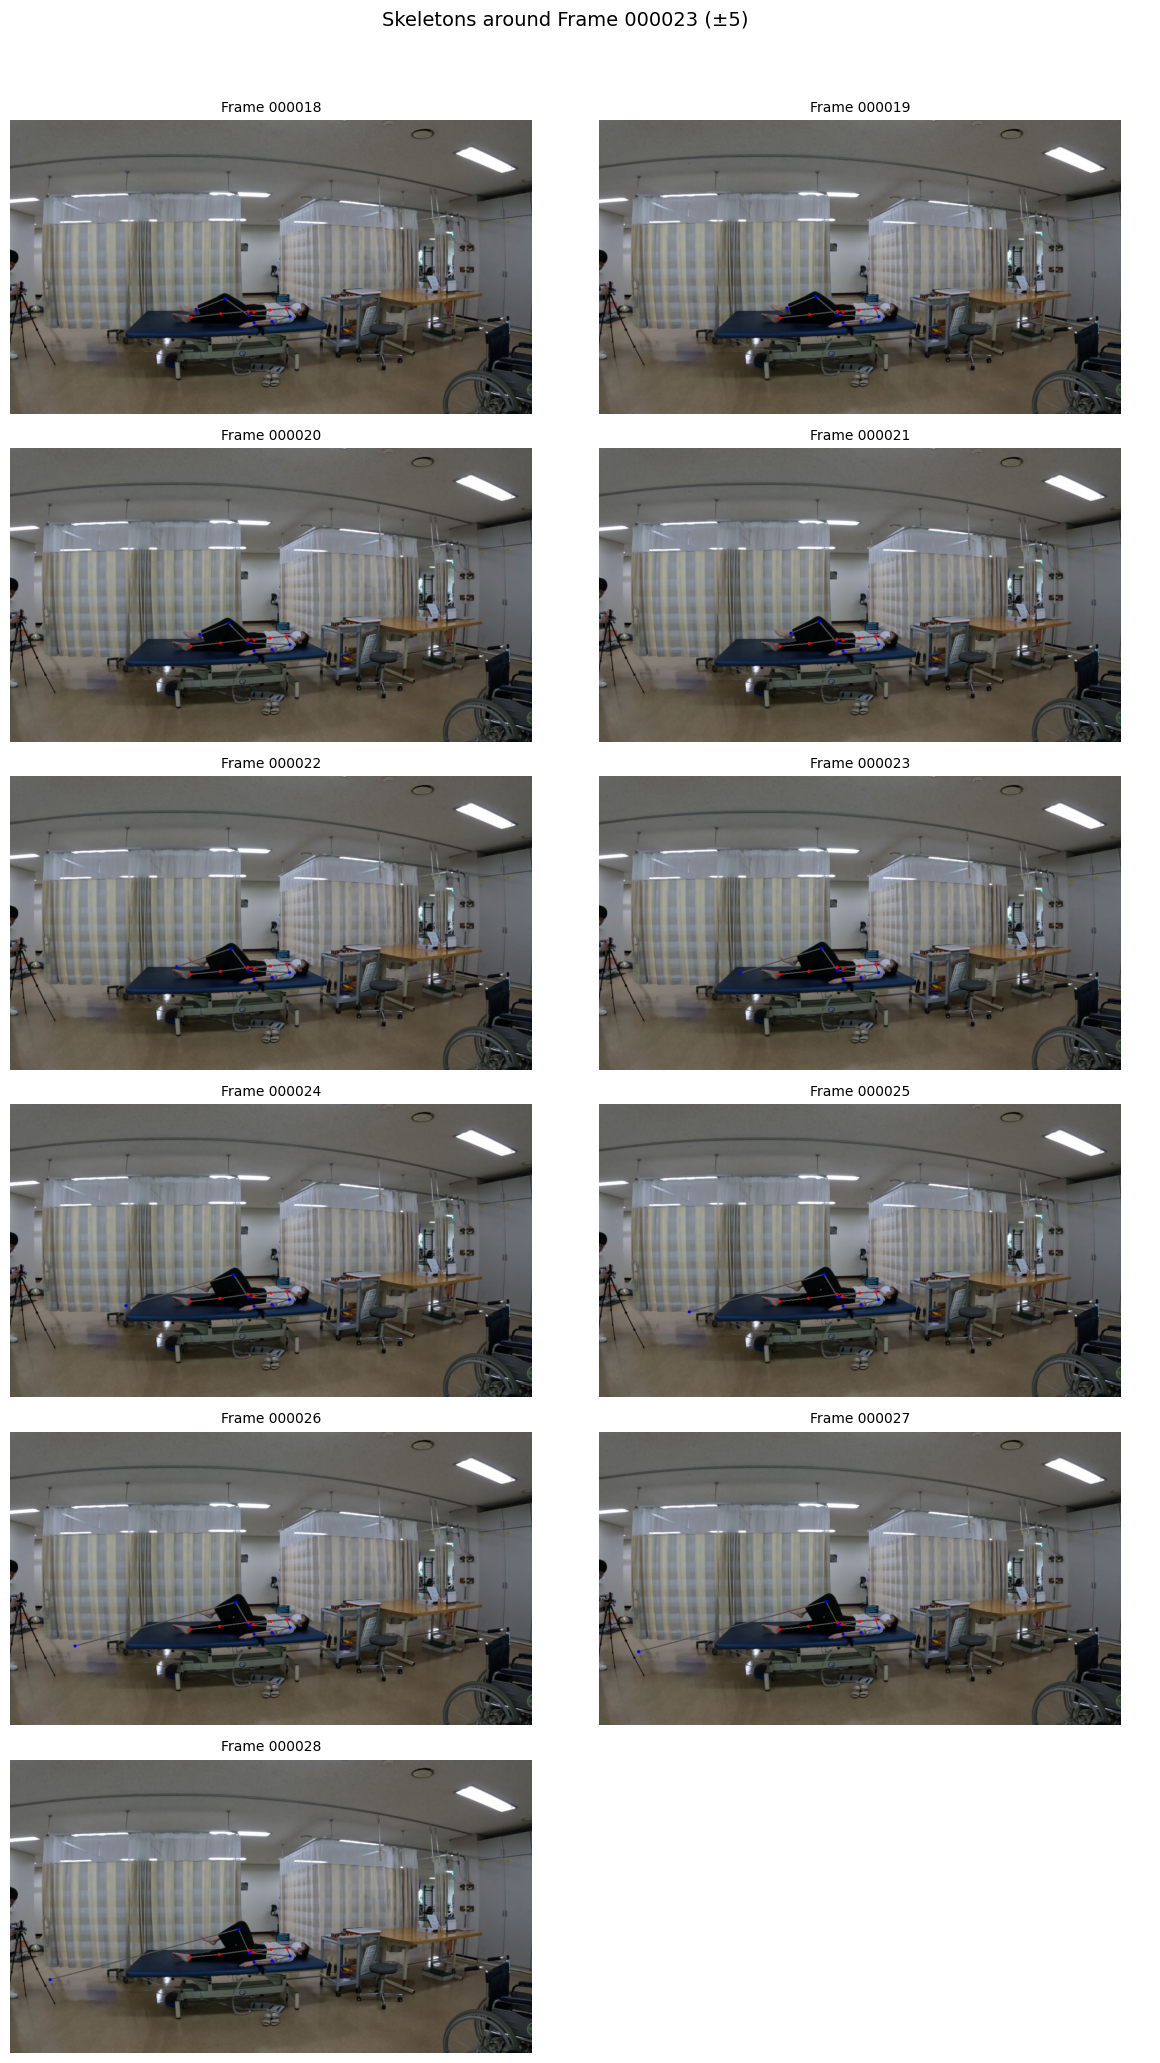

In [70]:
# 기준 프레임 100 → 앞뒤 5프레임씩 (총 11장)
visualize_frame_overlay(
    frame_dir=FRAME_DIR,
    json_dir=INTERP_DIR,
    frame_idx=23,
    window=5
)


## IQR 시각화

[INFO] 총 358개 JSON 로드 중...


100% 358/358 [00:00<00:00, 1531.05it/s]


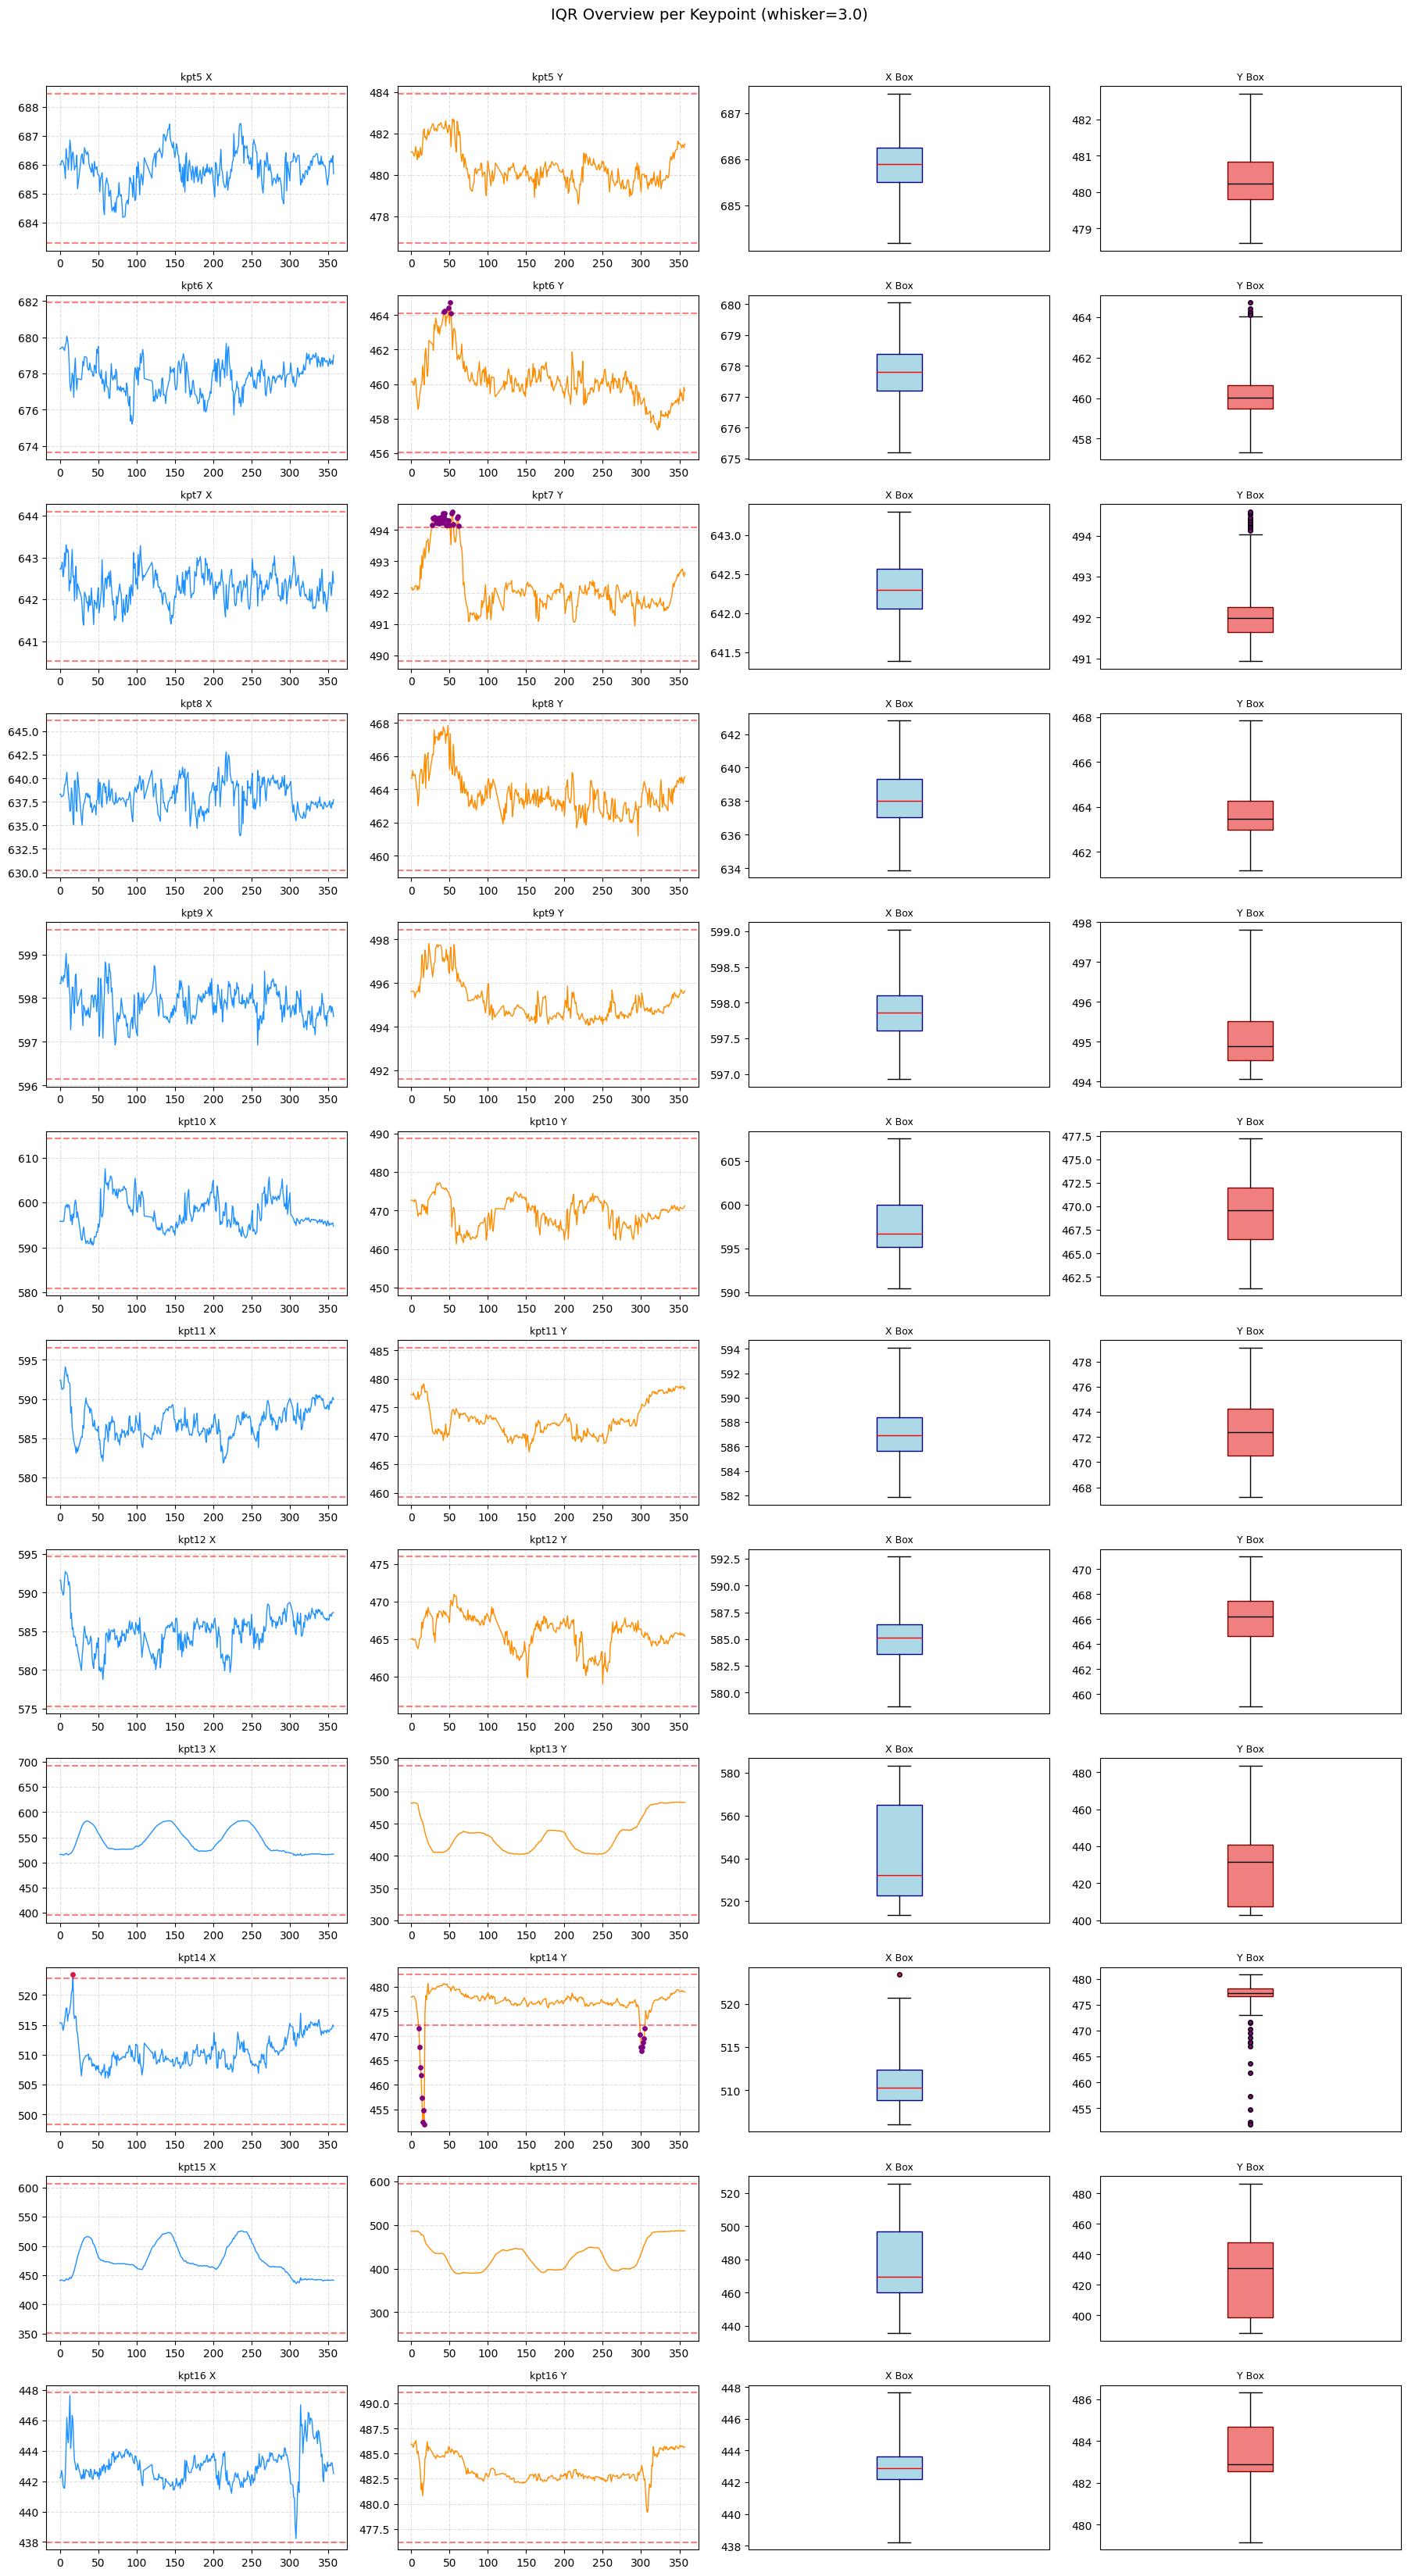

In [25]:
plot_keypoint_iqr_overview(INTERP_DIR, keypoint_range=(5, 17), whisker=3.0)

## velocity outlier 시각화

[INFO] 총 358개 JSON 로드 중...


Loading JSON: 100% 358/358 [00:01<00:00, 212.55it/s]



[INFO] Keypoint 15
  X outliers (2): [28, 120]
  Y outliers (5): [18, 28, 120, 300, 304]
  Speed outliers (4): [28, 120, 300, 304]


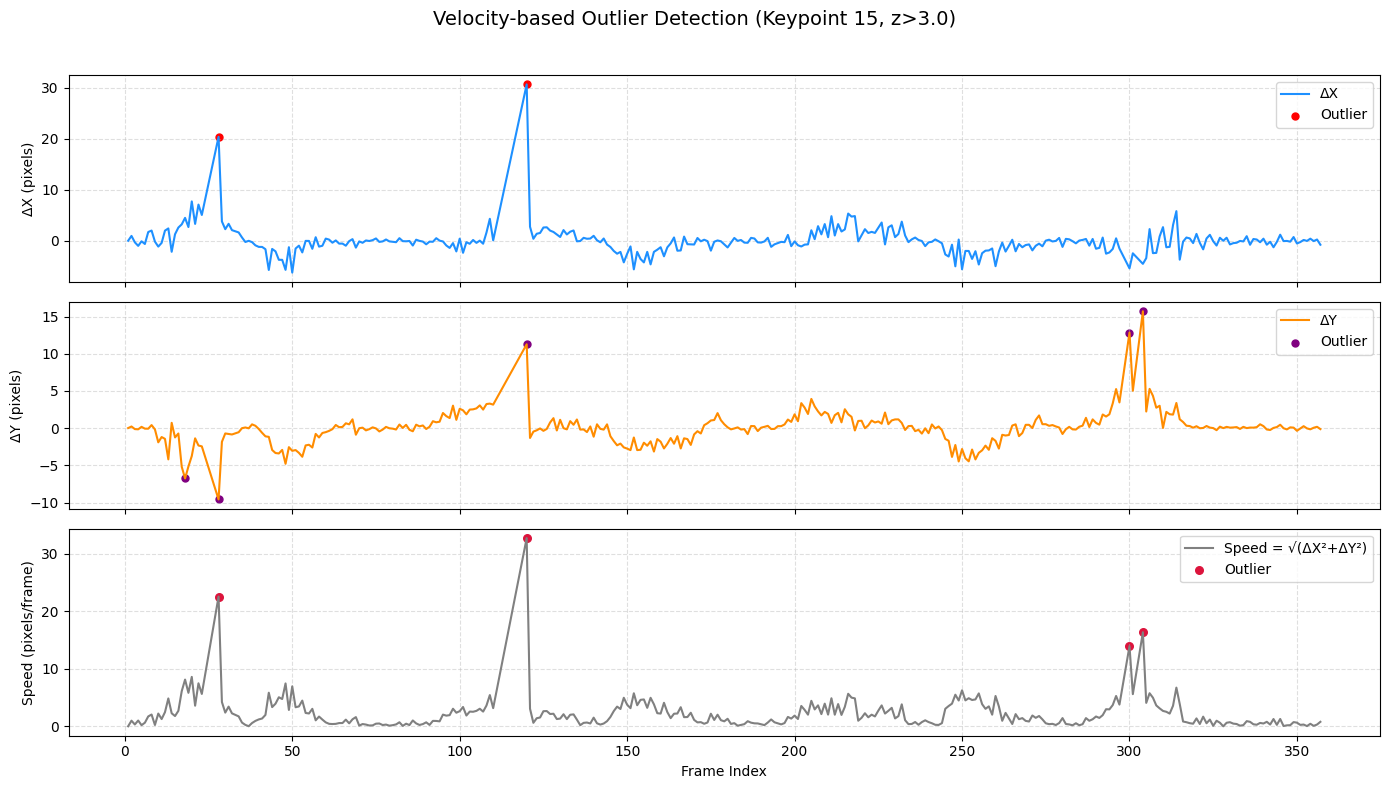

In [74]:
plot_velocity_outliers(
    json_dir=INTERP_DIR,
    target_kps=[15],
    z_thresh=3.0   # z-score 임계값 (2.5~3.0 추천)
)


# 보간 및 변경

## 가운데 인물 추출

In [72]:
# 더 엄격하게 (빠르게 움직이는 사람 제외)
extract_center_person_with_tracking(json_dir=INTERP_DIR, max_movement=100.0)


[INFO] 총 358개 프레임 처리 시작...
[INFO] Step 1: 35개 샘플에서 주인공 선택 중...


샘플링: 100% 35/35 [00:00<00:00, 343.57it/s]


✅ 주인공 선택: 프레임 189, 사람 0 (점수: -142.23)
[INFO] Step 2: 주인공 tracking 중... (최대 이동: 100.0px)


Tracking & 필터링: 100% 358/358 [00:02<00:00, 147.35it/s]

✅ 완료: 340/358 프레임에서 주인공 검출
⚠️  추적 실패: 18 프레임
✅ JSON 파일 덮어쓰기 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Treatment/lateral__hip_flexion_extension_bobath_table


## 특정 frame 선형 보간

In [16]:
manual_linear_interpolate_frames(
    json_dir=INTERP_DIR,
    target_frames= [24, 25, 26, 27, 33, 111, 112, 113, 114, 115, 116, 117, 118, 119, 298, 299, 302, 303],   # 연속 & 비연속 혼합
    target_kps=[5,6,7,8,9,10,11,12,13,14,15,16]
)


[INFO] 총 18개 target frame → 연속 구간 단위 보간 시작
✅ Frames 24~27: 연속 구간 보간 완료 ([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


IndexError: list index out of range

## keypoints 고정


In [13]:
# 예: 315 프레임의 8번, 10번 keypoints를 전체 프레임에 고정
fix_keypoints_across_frames(
    json_dir=INTERP_DIR,
    ref_frame=85,
    target_kps=[10]
)


[INFO] 기준 프레임 85의 [10]번 keypoints 좌표 고정값 → {10: array([574.04076798, 439.89596072])}


Fixing keypoints: 100% 361/361 [00:15<00:00, 23.61it/s]

✅ [10]번 keypoints를 프레임 85 기준으로 전체 고정 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Treatment/diagonal__slr_bobath_table


## IQR Outlier 보간

In [60]:
# 14, 16번 keypoints의 Outlier를 IQR=9 기준으로 선형 보간
interpolate_outliers(
    json_dir=INTERP_DIR,
    target_kps=[15],
    whisker=10.0
)


[INFO] 총 358개 JSON 로드 중...
[INFO] kpt15: Outlier 없음 ✅


Saving interpolated JSON: 100% 358/358 [00:07<00:00, 44.98it/s]

✅ Outlier 보간 완료 (연속 구간 포함, keypoints=[15], whisker=10.0) → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Treatment/lateral__hip_flexion_extension_bobath_table


## velocity 보간

In [67]:
interpolate_velocity_outliers(
    json_dir=INTERP_DIR,
    target_kps=[15],
    z_thresh=3.0
)


[INFO] 총 358개 JSON 로드 중...
[INFO] kpt15: 28개 Outlier → 연속 구간 단위 보간 중...
    → 보간 구간 22~26 (5프레임) 완료
    → 보간 구간 34~38 (5프레임) 완료
    → 보간 구간 109~113 (5프레임) 완료
    → 보간 구간 121~125 (5프레임) 완료
    → 보간 구간 297~301 (5프레임) 완료
    → 보간 구간 303~305 (3프레임) 완료


Saving interpolated JSON: 100% 358/358 [00:07<00:00, 48.80it/s]

✅ 연속 outlier 보간 완료 (keypoints=[15], z_thresh=3.0) → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Treatment/lateral__hip_flexion_extension_bobath_table


## smoothing 적용

In [55]:
smooth_keypoints(
    json_dir=INTERP_DIR,
    target_kps=[5,6,7,8,9,10,11,12,13,14,15,16],  # 어깨~발목 전체
    # target_kps=[12],  # 어깨~발목 전체
    window=5,        # 🔹 노이즈가 적을 땐 작은 윈도우 (3~5)
    method="moving"  # 🔹 단순 이동평균
)


[INFO] 총 358개 JSON 로드 → smoothing keypoints: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


Saving smoothed JSON: 100% 358/358 [00:07<00:00, 49.24it/s]

✅ Smoothing 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Treatment/lateral__hip_flexion_extension_bobath_table


# 영상 생성

In [27]:
import sys
sys.path.append("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter")

from functions.render_skeleton_video import render_skeleton_video
render_skeleton_video(
    frame_dir=FRAME_DIR,
    json_dir=INTERP_DIR,
    out_mp4=VIDEO_DIR,
    fps=30,
    model_type="coco17",
    
)

lateral__hip_flexion_extension_bobath_table: 100% 358/358 [00:04<00:00, 74.85frame/s]

✅ Skeleton overlay 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/3_MP4/AI_dataset/N02/N02_Treatment/lateral__hip_flexion_extension_bobath_table.mp4


# CSV is_train 업데이트

In [40]:
import pandas as pd
from pathlib import Path

# -------------------------------------------------------
# TARGET_ROW의 is_train 값 변경
# -------------------------------------------------------
meta.loc[TARGET_ROW, 'is_train'] = True  # True로 설정
print(f"[INFO] {TARGET_ROW}행의 is_train 값을 True로 변경했습니다.")

# -------------------------------------------------------
# CSV 저장
# -------------------------------------------------------
meta.to_csv(CSV_PATH, index=False)  # 덮어쓰기 저장
print(meta.loc[TARGET_ROW,'video_path'])
print(f"✅ 변경사항을 저장했습니다: {CSV_PATH}")


[INFO] 118행의 is_train 값을 True로 변경했습니다.
/workspace/nas203/ds_RehabilitationMedicineData/data/d02/AI_dataset/N02/N02_Treatment/lateral__hip_flexion_extension.mp4
✅ 변경사항을 저장했습니다: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/data/metadata_backup.csv
